# MWC 22 - Data Science
**Author**: Carlos Pérez Ricardo
**email**: carlos.peri.1997@gmail.com

## Objectives
Performn an exploratoty analysis of the data that enables to:
- Analyse the sales and the activity of clients
- Evaluate the impact of the promotion

Develop a predictive model that enables to know the type of segement each client belongs to as a function of the predictive variables. Download test_x. (The aim is to predict the variable: CLIENT_SEGMENT). 

In [1]:
!pip install lightgbm
!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import scipy
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as pp
from imblearn.over_sampling import SMOTE
from collections import Counter

# Models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

random_state=42

In [3]:
DIR = 'C:/Users/uhp07025/Downloads'
TARGET = 'CLIENT_SEGMENT'

save_model = False
plot = False
knn_imputing = True
include_pca_to_rf = False
include_orders_similarity = False

# Clients

The dataset clients contains clients information such as:
- **CLIENT ID**: Unique client identifier 
- **CLIENT SEGMENT**: Client segment
- **AVG CONSO**: Monthly average consumption (in pieces of fruits) calculated in late 2020 
- **AVG BASKET SIZE**: Average Basket size calculated in late 2020
- **RECEIVED_COMMUNICATION**: 1= Received promotion of their products / 0= Not Received 

In [4]:
clients_df = pd.read_csv(os.path.join(DIR, 'mwc22-client_table.csv'))

for col in clients_df.columns:
    try:
        clients_df[col] = clients_df[col].astype(np.float)
    except:
        clients_df[col] = clients_df[col].str.replace(',','.')
        clients_df[col] = clients_df[col].astype(float)

In [5]:
clients_df.head()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771.0,6.0,67.25,201.75,0.0
1,24321859.0,2.0,58.33,350.00,0.0
2,24321880.0,3.0,46.67,112.00,0.0
3,24321957.0,2.0,50.00,600.00,0.0
4,24321962.0,4.0,10.00,120.00,0.0


## Client Segment

The number of clients is different across each segment. The customer segment with the most number of clients is 3. At first sight, there is no imbalanced class (is to be said a class which is minoritary). Even though, if computing a model for each class we would find an unbalanced dataset. 

In [6]:
clients_df['CLIENT_SEGMENT'].value_counts()

3.0    8123
4.0    7927
2.0    6760
1.0    6505
5.0    3429
6.0    3140
Name: CLIENT_SEGMENT, dtype: int64

In [7]:
clients_df.describe()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
count,3.588400e+04,35884.000000,35884.000000,35884.000000,35884.000000
mean,2.706058e+07,3.123593,64.534437,181.218610,0.507998
std,8.835076e+06,1.512932,64.381932,129.604691,0.499943
min,1.807311e+07,1.000000,0.830000,10.000000,0.000000
25%,2.053311e+07,2.000000,20.830000,100.000000,0.000000
50%,2.462190e+07,3.000000,50.000000,160.000000,1.000000
75%,3.298538e+07,4.000000,88.170000,225.000000,1.000000
max,4.836594e+07,6.000000,2433.330000,3400.200000,1.000000


## Distribution of Consumption and Basket Size across every Client Segment

In this part, an analysis of the variables (AVG CONSO and AVG BASKET SIZE) is performed considering the different customer segments. In the last part, a study of the impact of Receiving a communication is performed.

As there are outliers in both (AVG CONSO and AVG BASKET SIZE), we will limit the maximum values.

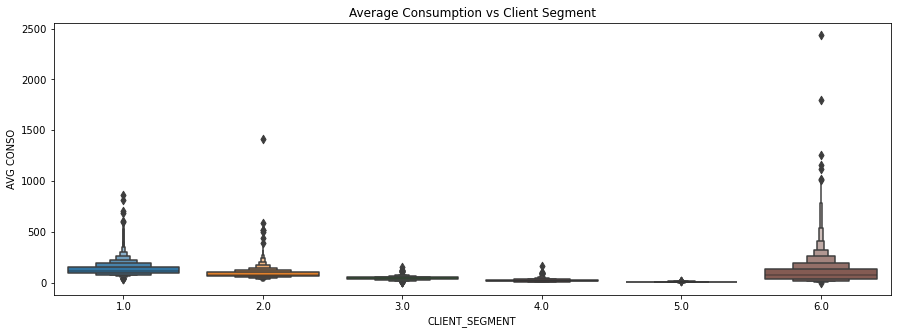

In [8]:
plt.figure(figsize=(15, 5))
ax = sns.boxenplot(data = clients_df, y='AVG CONSO', x='CLIENT_SEGMENT')
ax.set_title('Average Consumption vs Client Segment')
plt.show()

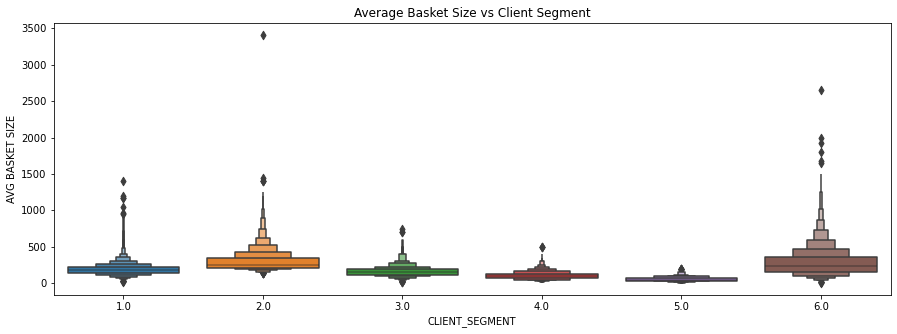

In [9]:
plt.figure(figsize=(15, 5))
ax = sns.boxenplot(data = clients_df, y='AVG BASKET SIZE', x='CLIENT_SEGMENT')
ax.set_title('Average Basket Size vs Client Segment')
plt.show()

We will clip AVG CONSO to a maximum value of 1400. And AVG BASKET SIZE would be limited to 1700.

In [10]:
clients_df['AVG CONSO'] = np.clip(clients_df['AVG CONSO'], a_max=1400, a_min=0)
clients_df['AVG BASKET SIZE'] = np.clip(clients_df['AVG BASKET SIZE'], a_max=1700, a_min=0)

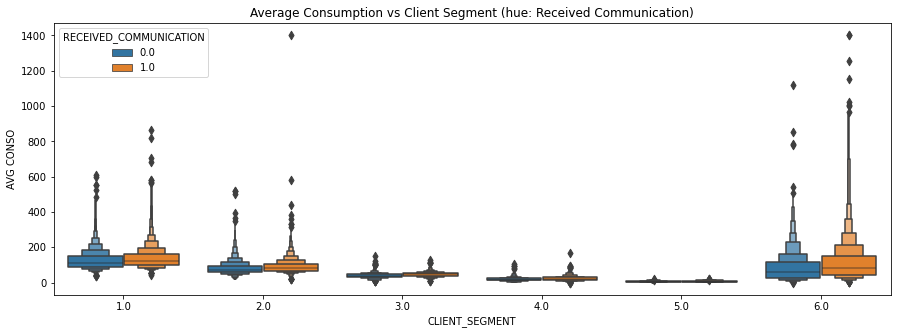

In [11]:
plt.figure(figsize=(15, 5))
ax = sns.boxenplot(data = clients_df, y='AVG CONSO', x='CLIENT_SEGMENT', hue='RECEIVED_COMMUNICATION')
ax.set_title('Average Consumption vs Client Segment (hue: Received Communication)')
plt.show()

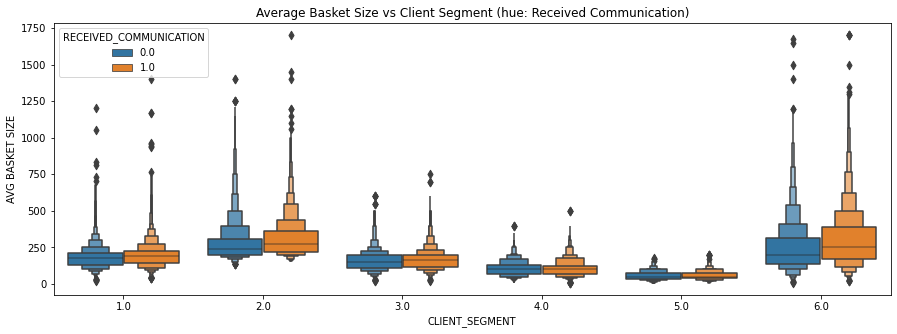

In [12]:
plt.figure(figsize=(15, 5))
ax = sns.boxenplot(data = clients_df, y='AVG BASKET SIZE', x='CLIENT_SEGMENT', hue='RECEIVED_COMMUNICATION')
ax.set_title('Average Basket Size vs Client Segment (hue: Received Communication)')
plt.show()

aaa

# Orders

In [13]:
orders_df = pd.read_csv(os.path.join(DIR, 'mwc22-orders_table.csv'))

In [14]:
orders_df.head()

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery


In [15]:
orders_df.shape

(66912, 4)

In [16]:
orders_expanded = pd.pivot_table(orders_df, index='ORDER ID', columns='FRUIT_PRODUCT', values = 'NB PRODS', aggfunc=[sum], fill_value=0)
orders_expanded.columns = orders_expanded.columns.droplevel(0)

In [17]:
order_clients = orders_df[['CLIENT ID', 'ORDER ID']]

In [18]:
orders = pd.merge(order_clients, orders_expanded, on=['ORDER ID'], how='outer')

In [19]:
fruits = [col for col in orders.columns if col not in ['ORDER ID','CLIENT ID']]
fruits

['Apple',
 'Apricot',
 'Banana',
 'Blueberry',
 'Cheery',
 'Coconut',
 'Devil Fruit',
 'Grape',
 'Jackfruit',
 'Kiwi',
 'Lemon',
 'Lime',
 'Mango',
 'Melon',
 'Nectarine',
 'Nuwe Fruit',
 'Orange',
 'Papaya',
 'Pear',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Strawberry',
 'Watermelon']

In [20]:
#clients_orders_summary = orders.groupby('CLIENT ID').agg([np.min, np.mean, np.max, np.sum])
clients_orders_summary = orders.groupby('CLIENT ID').agg([np.mean])
clients_orders_summary.columns = ['_'.join(col).strip() for col in clients_orders_summary.columns.values]

# Drop ORDER ID columns
cols = [col for col in clients_orders_summary.columns if not str.__contains__(col,"ORDER ID")]

clients_orders_summary = clients_orders_summary[cols]
clients_orders_summary

if False:
    for fruit in fruits:
        for metric in ['amin','mean','amax','sum']:
            x = pd.cut(np.array(clients_orders_summary[fruit+'_'+metric]), bins=5)

            le = LabelEncoder()
            x_ = le.fit_transform(x)

            clients_orders_summary[fruit+'_'+metric] = x_

In [21]:
clients_summary = orders.groupby('CLIENT ID')['ORDER ID'].agg(['count'])
clients_summary.columns = ['n_orders']

clients_orders_summary = pd.concat([clients_orders_summary, clients_summary], axis=1)

In [22]:
items_df = orders.set_index('CLIENT ID')
items_df['n_items'] = items_df[fruits].sum(axis=1)
items_df = items_df[['n_items']]
items_df.reset_index(inplace=True)

items_df

items_summary = items_df.groupby('CLIENT ID')['n_items'].agg([np.mean, np.max, np.sum])
#items_summary = items_df.groupby('CLIENT ID')['n_items'].agg([np.mean])
items_summary.columns = 'n_items_' + items_summary.columns
items_summary

,n_items_mean,n_items_amax,n_items_sum
CLIENT ID,,,
18070505,35.000000,35,175
18071016,50.000000,50,300
18071233,30.000000,30,240
18071668,13.714286,15,96
18072186,15.000000,15,30
...,...,...,...
48341696,6.666667,20,20
48341727,20.000000,20,80
48352045,10.000000,10,80


## Similarity of orders among same client

For each client how is the distribution of orders he/she has made? Do they make similar orders (ordering the same products) or client changes their tastes or preferences often?

To implement the similarity we would use cosine similarity. This enables to compute the semblance between two orders (or vectors) a similarity of 1 indicates that the orders are equal (or parallel if we talk about vectors). 

We can implement the same with the fruits and see what is the similarity between the fruits.

To compute the cosine similarity efficiently using sparse matrices I followed this post. http://na-o-ys.github.io/others/2015-11-07-sparse-vector-similarities.html

In [23]:
len(fruits)

24

In [24]:
A = orders[fruits]
# Fruits categorised to bins
for fruit in fruits:
    x = pd.cut(np.array(A[fruit]), bins=5)

    le = LabelEncoder()
    x_ = le.fit_transform(x)

    A[fruit] = x_

In [25]:
def cosine_similarities(mat):
    col_normed_mat = pp.normalize(mat.tocsc(), axis=0)
    return col_normed_mat.T * col_normed_mat

fruits_similarities = cosine_similarities(scipy.sparse.csc_matrix(A))

fruits_similarities

<24x24 sparse matrix of type '<class 'numpy.float64'>'
	with 532 stored elements in Compressed Sparse Row format>

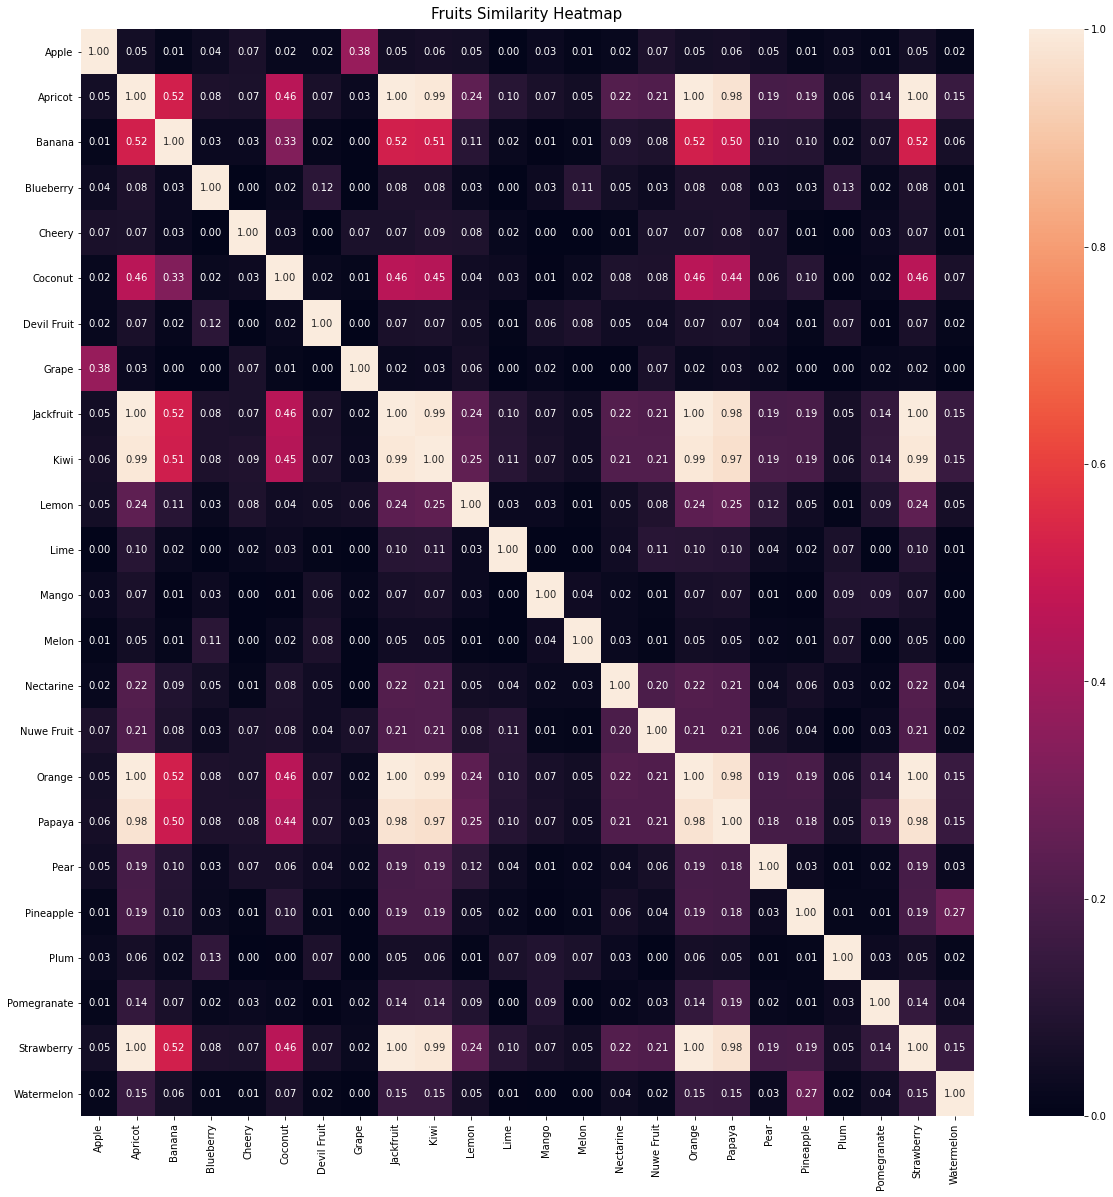

In [26]:
plt.figure(figsize=(20, 20))
fruits_matrix = pd.DataFrame(fruits_similarities.toarray(), index=fruits, columns=fruits)
heatmap = sns.heatmap(fruits_matrix, vmin=0, vmax=1, annot=True, fmt='.2f')
heatmap.set_title('Fruits Similarity Heatmap', fontdict={'fontsize':15}, pad=10);

In [27]:
clients_similarities_dict = {}

for client in orders['CLIENT ID'].unique():
    client_df = orders[ orders['CLIENT ID'] == client]
    client_df.drop(['CLIENT ID', 'ORDER ID'], axis=1, inplace=True)
    client_df = client_df.transpose()

    orders_similarities = cosine_similarities(scipy.sparse.csc_matrix(client_df))
    orders_similarities = pd.DataFrame(orders_similarities.toarray())

    a = np.array(orders_similarities)
        
    # Compute very similar orders a 1 others 0
    #a[a < 0.8] = 0
     
    try:
        #clients_similarities_dict[client] = {'mean': a[np.triu_indices(3)].mean(),'min': a[np.triu_indices(3)].min(), 'max': a[np.triu_indices(3)].max()}
        clients_similarities_dict[client] = {'min': a[np.triu_indices(3)].min()}
    except:
        #clients_similarities_dict[client] = {'mean': 0,'min': 0, 'max': 0}
        clients_similarities_dict[client] = {'min': 0}

In [28]:
clients_similarities_df = pd.DataFrame(clients_similarities_dict)
clients_similarities_df = clients_similarities_df.transpose()
clients_similarities_df.columns = 'orders_sim_' + clients_similarities_df.columns
clients_similarities_df

,orders_sim_min
18070505,1.0
18071016,1.0
18071233,1.0
18071668,1.0
18072186,0.0
...,...
48331345,1.0
48331450,0.0
48341696,0.0
48341727,1.0


In [29]:
clients_orders_summary = pd.concat([clients_orders_summary, items_summary], axis=1)

if include_orders_similarity:
    clients_orders_summary = pd.concat([clients_orders_summary, clients_similarities_df], axis=1)

clients_orders_summary['CLIENT ID'] = clients_orders_summary.index
clients_orders_summary

,Apple_mean,Apricot_mean,Banana_mean,Blueberry_mean,Cheery_mean,Coconut_mean,Devil Fruit_mean,Grape_mean,Jackfruit_mean,Kiwi_mean,...,Pineapple_mean,Plum_mean,Pomegranate_mean,Strawberry_mean,Watermelon_mean,n_orders,n_items_mean,n_items_amax,n_items_sum,CLIENT ID
CLIENT ID,,,,,,,,,,,,,,,,,,,,,
18070505,5.0,0.0,0.0,0.000000,5.0,0.0,0.000000,0.0,0.0,5.0,...,0.0,0.000000,0.0,0.0,0.0,5,35.000000,35,175,18070505
18071016,0.0,0.0,0.0,0.000000,15.0,0.0,0.000000,5.0,0.0,0.0,...,0.0,0.000000,0.0,10.0,5.0,6,50.000000,50,300,18071016
18071233,3.0,0.0,0.0,3.000000,9.0,0.0,3.000000,0.0,0.0,0.0,...,0.0,0.000000,3.0,0.0,0.0,8,30.000000,30,240,18071233
18071668,0.0,0.0,0.0,1.714286,0.0,0.0,1.714286,0.0,0.0,0.0,...,0.0,1.714286,0.0,0.0,0.0,7,13.714286,15,96,18071668
18072186,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,2,15.000000,15,30,18072186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48341696,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,3,6.666667,20,20,48341696
48341727,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,2.0,...,0.0,0.000000,0.0,0.0,0.0,4,20.000000,20,80,48341727
48352045,1.0,1.0,0.0,0.000000,0.0,1.0,0.000000,1.0,0.0,0.0,...,2.0,1.000000,0.0,0.0,2.0,8,10.000000,10,80,48352045


## Clustering considering clients preferences

In [30]:
from sklearn.preprocessing import LabelEncoder

clusters = orders[fruits]
clusters

for fruit in fruits:
    x = pd.cut(np.array(clusters[fruit]), bins=8)

    le = LabelEncoder()
    x_ = le.fit_transform(x)

    clusters[fruit] = x_

In [31]:
clusters

,Apple,Apricot,Banana,Blueberry,Cheery,Coconut,Devil Fruit,Grape,Jackfruit,Kiwi,...,Nectarine,Nuwe Fruit,Orange,Papaya,Pear,Pineapple,Plum,Pomegranate,Strawberry,Watermelon
0,1,3,1,0,0,1,0,0,2,2,...,0,0,2,2,1,1,0,0,1,0
1,1,3,1,0,0,1,0,0,2,2,...,0,0,2,2,1,1,0,0,1,0
2,1,3,1,0,0,1,0,0,2,2,...,0,0,2,2,1,1,0,0,1,0
3,1,3,1,0,0,1,0,0,2,2,...,0,0,2,2,1,1,0,0,1,0
4,1,3,1,0,0,1,0,0,2,2,...,0,0,2,2,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66907,0,3,1,0,0,1,0,0,2,2,...,0,0,2,2,0,1,0,0,1,1
66908,0,3,1,0,0,1,0,0,2,2,...,0,0,2,2,0,1,0,0,1,1
66909,0,3,1,0,0,1,0,0,2,2,...,0,0,2,2,0,1,0,0,1,1
66910,0,3,1,0,0,1,0,0,2,2,...,0,0,2,2,0,1,0,0,1,1


In [32]:
if plot == True:
    plt.figure(figsize=(30, 20))

    heatmap = sns.heatmap(clients_orders_summary.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f')

    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':1}, pad=5);

In [33]:
clients_orders_summary.columns

Index(['Apple_mean', 'Apricot_mean', 'Banana_mean', 'Blueberry_mean',
       'Cheery_mean', 'Coconut_mean', 'Devil Fruit_mean', 'Grape_mean',
       'Jackfruit_mean', 'Kiwi_mean', 'Lemon_mean', 'Lime_mean', 'Mango_mean',
       'Melon_mean', 'Nectarine_mean', 'Nuwe Fruit_mean', 'Orange_mean',
       'Papaya_mean', 'Pear_mean', 'Pineapple_mean', 'Plum_mean',
       'Pomegranate_mean', 'Strawberry_mean', 'Watermelon_mean', 'n_orders',
       'n_items_mean', 'n_items_amax', 'n_items_sum', 'CLIENT ID'],
      dtype='object')

There are columns with high correlation (> 0.98) we should only keep one. This high correlation can come from same products with different metrics (mean and max) or between same products (two products hadn't been bought).

We will discard these columns.

In [34]:
corr_matrix = clients_orders_summary.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
clients_orders_summary.drop(to_drop, axis=1, inplace=True)

In [35]:
if plot == True:
    plt.figure(figsize=(30, 20))

    heatmap = sns.heatmap(clients_orders_summary.corr(), vmin=-1, vmax=1, annot=True, fmt='.2f')

    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':1}, pad=5);

In [36]:
clients_orders_summary.columns

Index(['Apple_mean', 'Apricot_mean', 'Banana_mean', 'Blueberry_mean',
       'Cheery_mean', 'Coconut_mean', 'Devil Fruit_mean', 'Grape_mean',
       'Jackfruit_mean', 'Kiwi_mean', 'Lemon_mean', 'Lime_mean', 'Mango_mean',
       'Melon_mean', 'Nectarine_mean', 'Nuwe Fruit_mean', 'Orange_mean',
       'Papaya_mean', 'Pear_mean', 'Pineapple_mean', 'Plum_mean',
       'Pomegranate_mean', 'Strawberry_mean', 'Watermelon_mean', 'n_orders',
       'n_items_mean', 'n_items_sum', 'CLIENT ID'],
      dtype='object')

# Combine Orders info with Clients info

In [37]:
clients_orders_summary = clients_orders_summary.reset_index(drop=True)

In [38]:
all_df = pd.merge( clients_df, clients_orders_summary, on='CLIENT ID', how='outer')
all_df

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION,Apple_mean,Apricot_mean,Banana_mean,Blueberry_mean,Cheery_mean,...,Papaya_mean,Pear_mean,Pineapple_mean,Plum_mean,Pomegranate_mean,Strawberry_mean,Watermelon_mean,n_orders,n_items_mean,n_items_sum
0,24321771.0,6.0,67.25,201.75,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,2.000000,2.0
1,24321859.0,2.0,58.33,350.00,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24321880.0,3.0,46.67,112.00,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,10.000000,10.0
3,24321957.0,2.0,50.00,600.00,0.0,0.0,20.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,40.000000,80.0
4,24321962.0,4.0,10.00,120.00,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35886,18071233.0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,3.000000,9.0,...,0.0,0.0,0.0,0.000000,3.0,0.0,0.0,8.0,30.000000,240.0
35887,18071668.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.714286,0.0,...,0.0,0.0,0.0,1.714286,0.0,0.0,0.0,7.0,13.714286,96.0
35888,18072186.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,...,5.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,15.000000,30.0
35889,18072741.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,5.000000,0.0,...,0.0,0.0,3.0,0.000000,0.0,0.0,4.0,6.0,20.000000,120.0


There are clients in orders that are not in the client list. So we will not consider them.
And there are clients in the client list with no order history. 

In [39]:
all_df = all_df[ ~all_df['CLIENT_SEGMENT'].isnull() ]

all_df.set_index('CLIENT ID', inplace=True)

all_df.head()

,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION,Apple_mean,Apricot_mean,Banana_mean,Blueberry_mean,Cheery_mean,Coconut_mean,...,Papaya_mean,Pear_mean,Pineapple_mean,Plum_mean,Pomegranate_mean,Strawberry_mean,Watermelon_mean,n_orders,n_items_mean,n_items_sum
CLIENT ID,,,,,,,,,,,,,,,,,,,,,
24321771.0,6.0,67.25,201.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0
24321859.0,2.0,58.33,350.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24321880.0,3.0,46.67,112.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,10.0
24321957.0,2.0,50.00,600.00,0.0,0.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,40.0,80.0
24321962.0,4.0,10.00,120.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 

In [40]:
#all_df.fillna(-1, inplace=True)

In [41]:
all_df.shape

(35884, 31)

# Data Cleaning

When we merge the clients data with the orders data, we have observed that there are some clients that do not have any orders data. In this case the order's columns are NaNs.

What do we do with this data?
- We can impute this data with a number.
- We can use a KNN Imputer to find out we will ask neighbours which values do they have and compute the mean across them. As performing the KNN of all the data will last ages, we would select a sample.

In this case we perform a KNN imputation. I am not really convinced of this approach, as for a single row or client with no orders data, we have to fill all the orders columns, so we are guessing a lot of data. Even though, this approach leads to better results for the prediction models. 

Note that we only use the training data to perform the KNNImputer. 

In [42]:
selected_cols = [col for col in all_df.columns if col != TARGET]
X = all_df[selected_cols]
y = all_df[TARGET]

if knn_imputing:
    from sklearn.impute import KNNImputer

    # Too long
    #X = pd.DataFrame(imputer.fit_transform(X), columns = selected_cols, index=all_df.index)

    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(X.sample(10000))
    print('Fitting finished')
    X = pd.DataFrame(imputer.transform(X), columns = selected_cols, index=all_df.index)
    print('Transforming finished')
    
else:
    X = pd.DataFrame(X.fillna(-5))

Fitting finished
Transforming finished


In [43]:
# Categorization

In [44]:
if False:
    for col in ['AVG CONSO','AVG BASKET SIZE']:
        x = pd.cut(np.array(X[col]), bins=10)

        le = LabelEncoder()
        x_ = le.fit_transform(x)

        X[col+'_cat'] = x_

In [45]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=random_state)

n_classes = len(np.unique(y))

In [46]:
# Pre clustering with KMeans

# We have to use only train!!!

cluster_cols = [ f+'_mean' for f in fruits]
pre_cluster = X_train[cluster_cols]

from sklearn.cluster import KMeans

km = KMeans(n_clusters=8)
km.fit(pre_cluster)
 
X_train['pre_cluster'] = km.predict(pre_cluster)
X_test['pre_cluster'] = km.predict(X_test[cluster_cols])

# Compute Mean and Median among the cluster

X_train['pre_cluster_AVG_CONSO_mean'] = X_train.groupby('pre_cluster')['AVG CONSO'].transform( lambda x: x.mean())
X_train['pre_cluster_AVG_CONSO_median'] = X_train.groupby('pre_cluster')['AVG CONSO'].transform( lambda x: x.median())
X_train['pre_cluster_AVG_BASKET_mean'] = X_train.groupby('pre_cluster')['AVG BASKET SIZE'].transform( lambda x: x.mean())

train_agg = X_train[['pre_cluster','pre_cluster_AVG_CONSO_mean','pre_cluster_AVG_CONSO_median','pre_cluster_AVG_BASKET_mean']].drop_duplicates()

X_test = pd.merge( X_test, train_agg, on = ['pre_cluster'], how='left')

# Prediction models

In this section we will build several prediction models in order to obtain the model that best predicts our target. Several approaches will be considered:
- **PCA-KNN:** We would perform a Principal Componenent Analysis (PCA) to reduce the number of features and later the model would be a K-Nearest Neighbours model.
- **LDA-KNN:** We would perform a Linear Discriminant Analysis (LDA) to reduce the number of features and later the model would be a K-Nearest Neighbours model.
- **Multiclass RF**: Multiclass Random Forest Classifier that predicts the client segment directly. A single model all the client segments (multiclass classification)
- **SMOTE - Multi LGBM**: As the number of clients in each client segment is different and from previous models we had obseved that the overall solution is taking care of all segments equally, we perform an oversample with Synthetic Minority Over-sampling Technique (SMOTE) and later a multiclass Light Gradient Boosting model is trained. 
- **One for each - LGBM**: A Light Gradient Boosting model for each client segment is built (there are 6 models in total). Later, the model that predict 1 with the higher probability is selected. We would undersample the distribution for each model dataset.

The approach that provided the best results was **SMOTE - Multi LGBM**.

Other possibilities that could have been performed are:
- **SVM**: Support Vector Machines (however data should be normalised and columns combination (multiply x1*x2 would be advisable)- I would not expect better results, but who knows)
- **DBSCAN**: Similar to KNN (I would not expect better results, but who knows)
- **Neural Nets Multiclass Classifier**: This approach would have been tested if I had time. Several architectures would need to be tested. 
- **Stacked approach**: Rather than a single model solution, why not combine all models and obtain the average. It can be possible that one approach is really good at identifying cluster 6, and the other approaches are so good at it. So we could adquire the knowledge of every different approach.

## PCA-KNN

In [47]:
n_neighbors = 3


# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=30, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=4))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=3, random_state=random_state),
)

In [48]:
# Use a nearest neighbor classifier to evaluate the methods
pca_knn = KNeighborsClassifier(n_neighbors=4)

pca.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
pca_knn.fit(pca.transform(X_train), y_train)
    
y_pred_train = pca_knn.predict(pca.transform(X_train))
y_pred_test = pca_knn.predict(pca.transform(X_test))
    
# Compute the nearest neighbor accuracy on the embedded test set
print('PCA')
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

PCA
TRAIN: 0.6467240249970166
TEST: 0.5507487502894726


## LDA-KNN

In [49]:
# Use a nearest neighbor classifier to evaluate the methods
lda_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

lda.fit(X_train, y_train)

# Fit a nearest neighbor classifier on the embedded training set
lda_knn.fit(lda.transform(X_train), y_train)
    
y_pred_train = lda_knn.predict(lda.transform(X_train))
y_pred_test = lda_knn.predict(lda.transform(X_test))
    
# Compute the nearest neighbor accuracy on the embedded test set
print('LDA')
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

LDA
TRAIN: 0.6978913169796336
TEST: 0.6213350272374368


<AxesSubplot:>

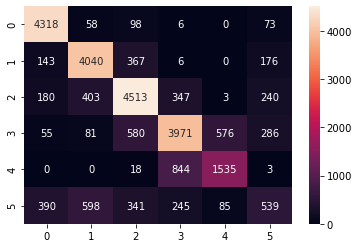

In [50]:
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

<AxesSubplot:>

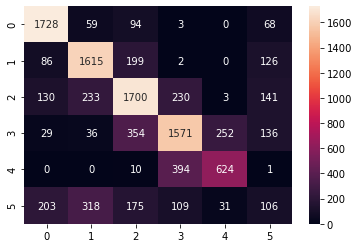

In [51]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random_state)

A possible approach would be to add the KNN predictions to the actual dataset. So we help the following model so it can focus on detecting client segments where the previous model has not detected well.

In [53]:
if include_pca_to_rf:
    X_train_ = X_train.copy(deep=True)
    X_test_ = X_test.copy(deep=True)

    X_train_['pca_knn'] = pca_knn.predict(pca.transform(X_train))
    X_test_['pca_knn'] = pca_knn.predict(pca.transform(X_test))

    X_train_['lda_knn'] = lda_knn.predict(lda.transform(X_train))
    X_test_['lda_knn'] = lda_knn.predict(lda.transform(X_test))

else:
    
    X_train_ = X_train.copy(deep=True)
    X_test_ = X_test.copy(deep=True)

## Multiclass RF

In [54]:
X_train = X_train_.copy(deep=True)
X_test = X_test_.copy(deep=True)

In [55]:
rf = RandomForestClassifier(n_estimators = 400, max_depth=60, min_samples_leaf=5, random_state=random_state)
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

TRAIN: 0.7313718047784583
TEST: 0.6924177813972089


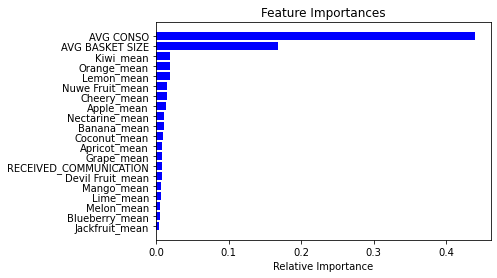

In [56]:
importances = rf.feature_importances_[:20]
indices = np.argsort(importances)
features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [57]:
rf = RandomForestClassifier(random_state=random_state)

param_dist = {"max_depth": [10, 20, 30, 50],
                  "n_estimators": [150, 250, 450, 550]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 4, scoring='f1_macro', verbose=10)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
    
print(model)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

Fitting 4 folds for each of 16 candidates, totalling 64 fits
RandomForestClassifier(max_depth=50, n_estimators=450, random_state=42)
TRAIN: 0.8536015303560899
TEST: 0.6928031728663743


<AxesSubplot:>

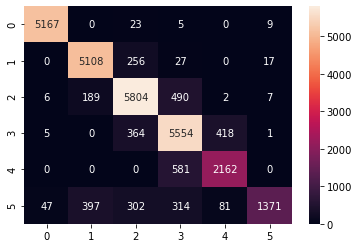

In [58]:
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

<AxesSubplot:>

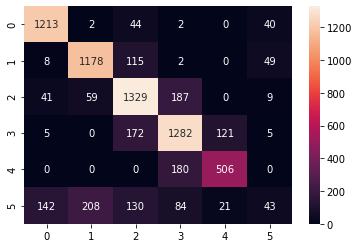

In [59]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

## SMOTE - Multi LGBM

In [60]:
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(X_train, y_train)

print('Before Sampling')
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\n After Sampling')
counter = Counter(y_train_ov)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Before Sampling
Class=4, n=6342 (17.674%)
Class=2, n=5408 (15.071%)
Class=3, n=6498 (18.108%)
Class=5, n=2743 (7.644%)
Class=6, n=2512 (7.000%)
Class=1, n=5204 (14.502%)

 After Sampling
Class=4, n=6498 (18.108%)
Class=2, n=6498 (18.108%)
Class=3, n=6498 (18.108%)
Class=5, n=6498 (18.108%)
Class=6, n=6498 (18.108%)
Class=1, n=6498 (18.108%)


In [ ]:
rf = RandomForestClassifier(random_state=random_state)

param_dist = {"max_depth": [10, 20, 30, 50],
                  "n_estimators": [150, 250, 450, 550]
                 }
grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_dist, cv = 5, scoring='f1_macro', verbose=20)
grid_search.fit(X_train_ov, y_train_ov)
model = grid_search.best_estimator_
    
print(model)
y_pred_train_ = model.predict(X_train_ov)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("TRAIN (oversample):", f1_score(y_train_ov, y_pred_train_, average='macro'))
print("TRAIN:", f1_score(y_train, y_pred_train, average='macro'))
print("TEST:", f1_score(y_test, y_pred_test, average='macro'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
cf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

In [ ]:
import pickle
filename = 'oversample_model.sav'
pickle.dump(model, open(filename, 'wb'))

## One for each - LGBM

In [ ]:


# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state)

all_pred_train = pd.DataFrame()
all_pred_test = pd.DataFrame()

for segment in range(1,n_classes+1):
    print(segment)
    
    y_train_onehot = y_train.apply(lambda x:1 if x == segment else 0)
    y_test_onehot = y_test.apply(lambda x:1 if x == segment else 0)

    true = y_train_onehot.loc[ y_train_onehot == 1].index.to_list()
    non_true = y_train_onehot.loc[ y_train_onehot == 0].sample( round(len(true)*2) ).index.to_list()
    idx = true + non_true
    
    X_train_ = X_train.loc[idx]
    y_train_onehot_ = y_train_onehot.loc[idx]
    
    #from imblearn.over_sampling import SMOTE
    #oversample = SMOTE()
    #X_train_, y_train_onehot_ = oversample.fit_resample(X_train, y_train_onehot)
    
    lgtrain_ = lgb.Dataset(X_train_, label=y_train_onehot_)
    
    lg = lgb.LGBMClassifier(silent=False)
    param_dist = {"max_depth": [20,30,50],
                  "learning_rate" : [0.05, 0.1],
                  "num_leaves": [20,30,50],
                  "n_estimators": [150, 250]
                 }
    grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=10)
    grid_search.fit(X_train_, y_train_onehot_)
    model = grid_search.best_estimator_
    
    print(model)
    y_pred_train_ = model.predict(X_train_)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print("TRAIN (Oversample):", f1_score(y_train_onehot_, y_pred_train_))
    print("TRAIN:", f1_score(y_train_onehot, y_pred_train))
    print("TEST:", f1_score(y_test_onehot, y_pred_test))
    
    y_proba_train = model.predict_proba(X_train)
    y_proba_test = model.predict_proba(X_test)
    
    all_pred_train = pd.concat([all_pred_train, pd.DataFrame({'pred_'+str(segment):y_pred_train,'proba_'+str(segment):y_proba_train[:, 0]})], axis=1)
    all_pred_test = pd.concat([all_pred_test, pd.DataFrame({'pred_'+str(segment):y_pred_test,'proba_'+str(segment):y_proba_test[:, 0]})], axis=1)  
    
#all_pred_train['result'] = y_train.values
#all_pred_test['result'] = y_test.values

In [ ]:
all_pred_train

In [ ]:
def obtain_results_(df):
    proba_cols = [col for col in df.columns if str.__contains__(col,"proba")]

    for col in range(1,7):
        proba = 'proba_'+str(col)
        pred = 'pred_'+str(col)
        df.loc[df[pred] == 0,proba] = -abs(df.loc[all_pred_train[pred]== 0,proba])

    maxValueIndex = df[proba_cols].idxmax(axis = 1)

    df['FINAL'] = maxValueIndex

    df['FINAL'] = df['FINAL'].apply( lambda x: x.split('_')[1]).astype(int)
    
    return(df)

In [ ]:
all_pred_train = obtain_results_(all_pred_train)
all_pred_test = obtain_results_(all_pred_test)

all_pred_train['ACTUAL'] = y_train.values
all_pred_test['ACTUAL'] = y_test.values
all_pred_train

In [ ]:
all_pred_train['ERROR'] = all_pred_train['ACTUAL'] == all_pred_train['FINAL']
all_pred_train

In [ ]:
cf_matrix = confusion_matrix(all_pred_train['FINAL'], all_pred_train['ACTUAL'])
sns.heatmap(cf_matrix, annot=True, fmt='.0f')

In [ ]:
f1_score(y_train, all_pred_train['FINAL'], average='macro')

In [ ]:
f1_score(y_test, all_pred_test['FINAL'], average='macro')

# Prediction

The approach that led to the best model is **SMOTE - Multi LGBM**. So we will use this model to predict.

In [ ]:
pred_df = pd.read_csv(os.path.join(DIR,'mwc22-client_table+-+test_x.csv'))

for col in pred_df.columns:
    try:
        pred_df[col] = pred_df[col].astype(np.float)
    except:
        pred_df[col] = pred_df[col].str.replace(',','.')
        pred_df[col] = pred_df[col].astype(float)

pred_df.head()

The following steps have to be performed to perform a prediction:
- Correct format in numeric variables
- Clip maximum values of AVG CONSO and AVG BASKET SIZE
- Join orders data.
- Performing KNN Imputing 
- Add KMeans clusters information

In [ ]:
pred_df['AVG CONSO'] = np.clip(pred_df['AVG CONSO'], a_max=1400, a_min=0)
pred_df['AVG BASKET SIZE'] = np.clip(pred_df['AVG BASKET SIZE'], a_max=1700, a_min=0)

In [ ]:
pred_all_df = pd.merge( pred_df, clients_orders_summary, on='CLIENT ID', how='left')
pred_all_df.set_index('CLIENT ID',inplace=True)

In [ ]:
if knn_imputing:
    print('Transforming started')
    X = pd.DataFrame(imputer.transform(pred_all_df), columns = selected_cols, index=pred_all_df.index)
    print('Transforming finished')
else:
    X = pd.DataFrame(X.fillna(-5))

In [ ]:
# Pre clustering with KMeans
X['pre_cluster'] = km.predict(X[cluster_cols])
#X = pd.merge( X, train_agg, on = ['pre_cluster'], how='left')
X

In [ ]:
train_agg

In [ ]:
selected_cols = model.feature_name_
X = X[selected_cols]

In [ ]:
X_train.columns

In [ ]:
y_final = model.predict(X)
y_final

## Submision file

The final submision must be 2 columns: CLIENT ID and CLIENT_SEGMENT

In [ ]:
submission = pd.DataFrame({'CLIENT ID': X.index, 'CLIENT_SEGMENT': y_final})
submission.to_csv('results.csv')

In [ ]:
model.feature_name_